In [ ]:
import numpy as np

np.load

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os

experiment_key = ""
choose_metric = "mse"

hyperparam1_labels= ["3 Groups", "4 Groups", "5 Groups", "6 Groups", "7 Groups"]
hyperparam2_labels=["1", "2", "3", "4"]
model_labels= ['Bridged Clustering', 'KNN', 'FixMatch', 'Laplacian RLS', 'TSVR', 'TNNR', 'UCVME', 'GCN', 'KMM','EM',"EOT","GW"]

ami_x = np.load(f"results/{experiment_key}/ami_x.npy")
ami_y = np.load(f"results/{experiment_key}/ami_y.npy")
mae = np.load(f"results/{experiment_key}/mae.npy")
mse = np.load(f"results/{experiment_key}/mse.npy")
accuracy = np.load(f"results/{experiment_key}/accuracy.npy")

In [ ]:
if ami_x.ndim == 5:
    ami_x = ami_x[:, 0, :, 0, :]
    ami_y = ami_y[:, 0, :, 0, :]
    accuracy = accuracy[:, 0, :, 0, :]
    mae = mae[:, 0, :, 0, :, :]
    mse = mse[:, 0, :, 0, :, :]

print("ami_x shape:", ami_x.shape)
print("ami_y shape:", ami_y.shape)
print("accuracy shape:", accuracy.shape)
print("mae shape:", mae.shape)
print("mse shape:", mse.shape)
if choose_metric == "mae":
    metric = mae
elif choose_metric == "mse":
    metric = mse

ami_x shape: (5, 4, 30)
ami_y shape: (5, 4, 30)
accuracy shape: (5, 4, 30)
mae shape: (5, 4, 14, 30)
mse shape: (5, 4, 14, 30)


In [ ]:
experiment_key_list = []

metrics_list = []
for key in experiment_key_list:
    mse = np.load(f"results/{key}/mse.npy")
    if mse.ndim == 6:
        mse = mse[:, 0, :, 0, :, :]
    metrics_list.append(mse)

for i, metric in enumerate(metrics_list):
    print("Running experiment: ", experiment_key_list[i])
    winners = np.argmin(metric, axis=2)   # shape (5, 4, 30)
    win_counts = np.zeros(len(model_labels), dtype=int)
    for i in range(len(model_labels)):
        win_counts[i] = np.sum(winners == i)

    # Step 3: Convert to win-rates (fraction of 600 trials)
    total_trials = metric.shape[0] * metric.shape[1] * metric.shape[3]  # 600
    win_rates = win_counts / total_trials

    # Print results
    for model, rate in zip(model_labels, win_rates):
        print(f"{model:20s}: {rate:.3f}")

Running experiment:  101_bioscan_ind
Bridged Clustering  : 0.673
KNN                 : 0.000
FixMatch            : 0.000
Laplacian RLS       : 0.000
TSVR                : 0.000
TNNR                : 0.175
UCVME               : 0.000
GCN                 : 0.000
KMM                 : 0.000
EM                  : 0.000
EOT                 : 0.113
GW                  : 0.010
Running experiment:  102_bioscan_rev_ind
Bridged Clustering  : 0.610
KNN                 : 0.000
FixMatch            : 0.000
Laplacian RLS       : 0.000
TSVR                : 0.000
TNNR                : 0.000
UCVME               : 0.000
GCN                 : 0.000
KMM                 : 0.000
EM                  : 0.000
EOT                 : 0.013
GW                  : 0.008
Running experiment:  100_coco_ind
Bridged Clustering  : 0.695
KNN                 : 0.000
FixMatch            : 0.000
Laplacian RLS       : 0.000
TSVR                : 0.000
TNNR                : 0.000
UCVME               : 0.000
GCN                 

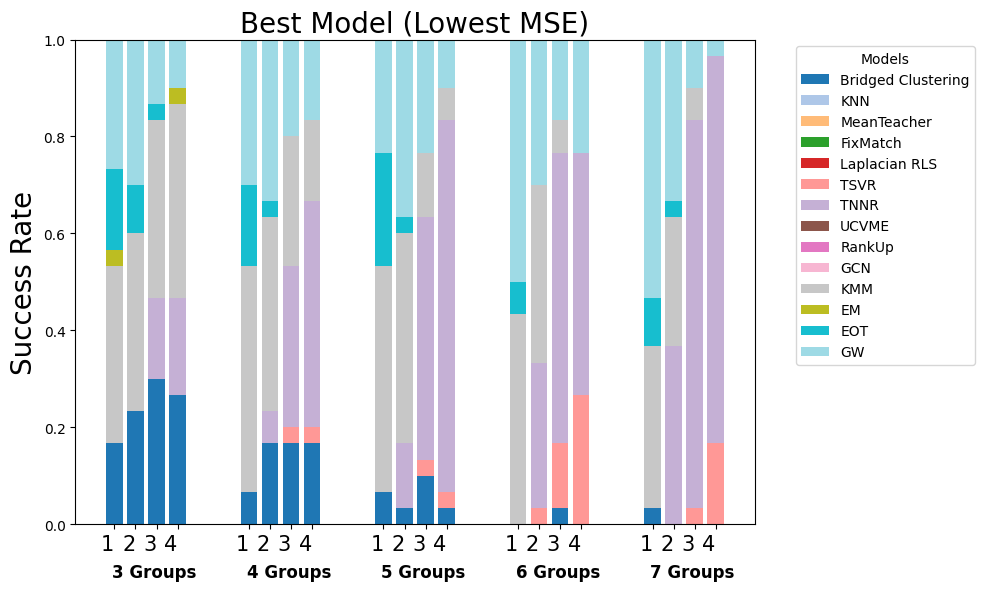

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Assumes you already have total_results_matrix of shape (3, 4, n_models, n_trials) ---
n_h1, n_h2, n_models, n_trials = metric.shape

# 1) Compute success rates
success_rates = np.zeros((n_h1, n_h2, n_models))
for i in range(n_h1):
    for j in range(n_h2):
        losses = metric[i, j]        # (n_models, n_trials)
        if choose_metric == "bleu" or choose_metric == "chrf":
            winners = np.argmax(losses, axis=0)
        else:
            winners = np.argmin(losses, axis=0)
        for k in range(n_models):
            success_rates[i, j, k] = np.mean(winners == k)

# 2) Layout parameters
bar_width   = 0.18
intra_gap   = 0.05
group_gap   = 0.6
group_width = n_h2 * bar_width + (n_h2 - 1) * intra_gap

# Build x‐positions for each of the 12 bars
positions = []
for i in range(n_h1):
    base = i * (group_width + group_gap)
    for j in range(n_h2):
        x = base + j * (bar_width + intra_gap)
        positions.append(x)
positions = np.array(positions)

# 3) Pick n_models distinct colors
cmap   = plt.get_cmap('tab20')
colors = [cmap(t) for t in np.linspace(0, 1, n_models)]

# 4) Plot the stacked bars
fig, ax = plt.subplots(figsize=(10, 6))
for idx, x in enumerate(positions):
    i = idx // n_h2    # which hyperparam1 group
    j = idx % n_h2     # which hyperparam2 bar in that group
    bottom = 0.0
    for k in range(n_models):
        rate = success_rates[i, j, k]
        ax.bar(x, rate, bar_width, bottom=bottom, color=colors[k])
        bottom += rate

# 5) Secondary ticks for hyperparam2_labels
ax.set_xticks(positions)
# repeat hyperparam2_labels for each hyperparam1 group
ax.set_xticklabels(hyperparam2_labels * n_h1, rotation=0, ha='right', fontsize=15)

# 6) Add hyperparam1 group labels centered beneath the bars
group_centers = [
    i * (group_width + group_gap) + group_width / 2
    for i in range(n_h1)
]
for i, center in enumerate(group_centers):
    ax.text(center, -0.08, hyperparam1_labels[i],
            transform=ax.get_xaxis_transform(),
            ha='center', va='top', fontsize=12, fontweight='bold')

ax.set_ylabel("Success Rate", fontsize=20)
ax.set_ylim(0, 1)
ax.set_title("Best Model (Lowest MSE)", fontsize=20)

# 7) Legend
ax.legend(model_labels, bbox_to_anchor=(1.05, 1),
          loc='upper left', title="Models")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from scipy.stats import friedmanchisquare, rankdata, wilcoxon
from statsmodels.stats.multitest import multipletests

metric = mse

# Your result tensor: (3, 4, 13, 20) → reshape to (12 settings, 13 models, 20 trials)
results_reshaped = metric.reshape(-1, 14, 30)  # shape: (12, 13, 20)

# Stack all setting/trial dimensions: shape → (13 models, 12×20 trials)
n_settings, n_models, n_trials = results_reshaped.shape
data_per_model = results_reshaped.transpose(1, 0, 2).reshape(n_models, -1)  # shape: (13, 240)

# Run Friedman test (input: list of arrays, one per model)
friedman_stat, friedman_p = friedmanchisquare(*data_per_model)
print(f"Friedman test statistic = {friedman_stat:.3f}, p-value = {friedman_p:.3g}")

# Post-hoc: Wilcoxon signed-rank test between BKM (index 0) and others
p_values = []
stat_values = []

bkm_scores = data_per_model[0]
for i in range(1, n_models):
    stat, p = wilcoxon(bkm_scores, data_per_model[i])
    stat_values.append(stat)
    p_values.append(p)

# Corrections
_, p_bonf, _, _ = multipletests(p_values, method='bonferroni')
_, p_bh, _, _ = multipletests(p_values, method='fdr_bh')

# Display post-hoc results
print("\nWilcoxon test: BKM vs each baseline")
for i, (raw, bonf, bh) in enumerate(zip(p_values, p_bonf, p_bh), start=1):
    print(f"Baseline {i:<2}: raw p = {raw:.3g}, Bonferroni = {bonf:.3g}, BH = {bh:.3g}")

Friedman test statistic = 6680.580, p-value = 0

Wilcoxon test: BKM vs each baseline
Baseline 1 : raw p = 5.98e-100, Bonferroni = 7.77e-99, BH = 1.11e-99
Baseline 2 : raw p = 5.98e-100, Bonferroni = 7.77e-99, BH = 1.11e-99
Baseline 3 : raw p = 5.98e-100, Bonferroni = 7.77e-99, BH = 1.11e-99
Baseline 4 : raw p = 5.98e-100, Bonferroni = 7.77e-99, BH = 1.11e-99
Baseline 5 : raw p = 1.36e-99, Bonferroni = 1.77e-98, BH = 1.97e-99
Baseline 6 : raw p = 1.17e-99, Bonferroni = 1.52e-98, BH = 1.9e-99
Baseline 7 : raw p = 5.98e-100, Bonferroni = 7.77e-99, BH = 1.11e-99
Baseline 8 : raw p = 5.98e-100, Bonferroni = 7.77e-99, BH = 1.11e-99
Baseline 9 : raw p = 5.98e-100, Bonferroni = 7.77e-99, BH = 1.11e-99
Baseline 10: raw p = 8.52e-85, Bonferroni = 1.11e-83, BH = 9.23e-85
Baseline 11: raw p = 1.69e-98, Bonferroni = 2.2e-97, BH = 2e-98
Baseline 12: raw p = 0.000317, Bonferroni = 0.00412, BH = 0.000317
Baseline 13: raw p = 9.78e-99, Bonferroni = 1.27e-97, BH = 1.27e-98


shape of ami_gene_matrix: (5, 120)


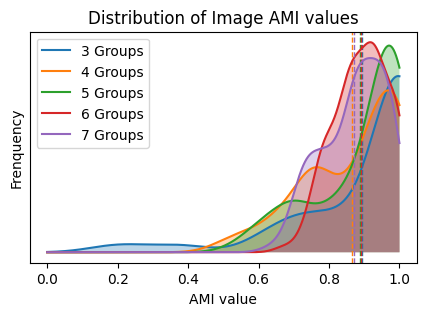

shape of ami_gene_matrix: (5, 120)


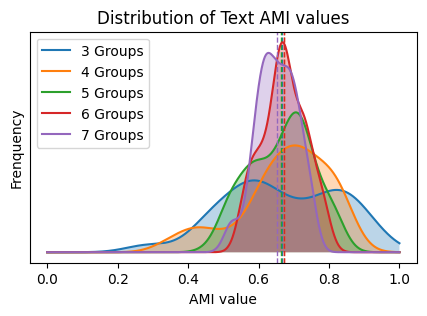

In [ ]:
ami_matrix = ami_x.reshape(ami_x.shape[0], -1)
print("shape of ami_gene_matrix:", ami_matrix.shape)

# Prepare x-axis
x = np.linspace(0, 1, 2000)

settings = hyperparam1_labels

# Create a single plot for all three settings
plt.figure(figsize=(5, 3))
for idx, row in enumerate(ami_matrix):
    # Compute KDE
    kde = gaussian_kde(row)
    density = kde(x)
    
    # Plot and fill
    plt.plot(x, density, label=settings[idx])
    plt.fill_between(x, density, alpha=0.3)

    mean_val = np.mean(row)
    plt.axvline(mean_val, linestyle='--', linewidth=1, color=plt.gca().lines[-1].get_color(),label='_nolegend_')

# Labels and legend
plt.xlabel('AMI value')
plt.ylabel('Frenquency')
plt.yticks([])
plt.title('Distribution of Image AMI values')
plt.legend(loc='upper left')

plt.show()

ami_matrix = ami_y.reshape(ami_y.shape[0], -1)
print("shape of ami_gene_matrix:", ami_matrix.shape)

# Prepare x-axis
x = np.linspace(0, 1, 2000)

# Create a single plot for all three settings
plt.figure(figsize=(5, 3))
for idx, row in enumerate(ami_matrix):
    # Compute KDE
    kde = gaussian_kde(row)
    density = kde(x)
    
    # Plot and fill
    plt.plot(x, density, label=settings[idx])
    plt.fill_between(x, density, alpha=0.3)

    mean_val = np.mean(row)
    plt.axvline(mean_val, linestyle='--', linewidth=1, color=plt.gca().lines[-1].get_color(),label='_nolegend_')

# Labels and legend
plt.xlabel('AMI value')
plt.ylabel('Frenquency')
plt.yticks([])
plt.title('Distribution of Text AMI values')
plt.legend(loc='upper left')

plt.show()

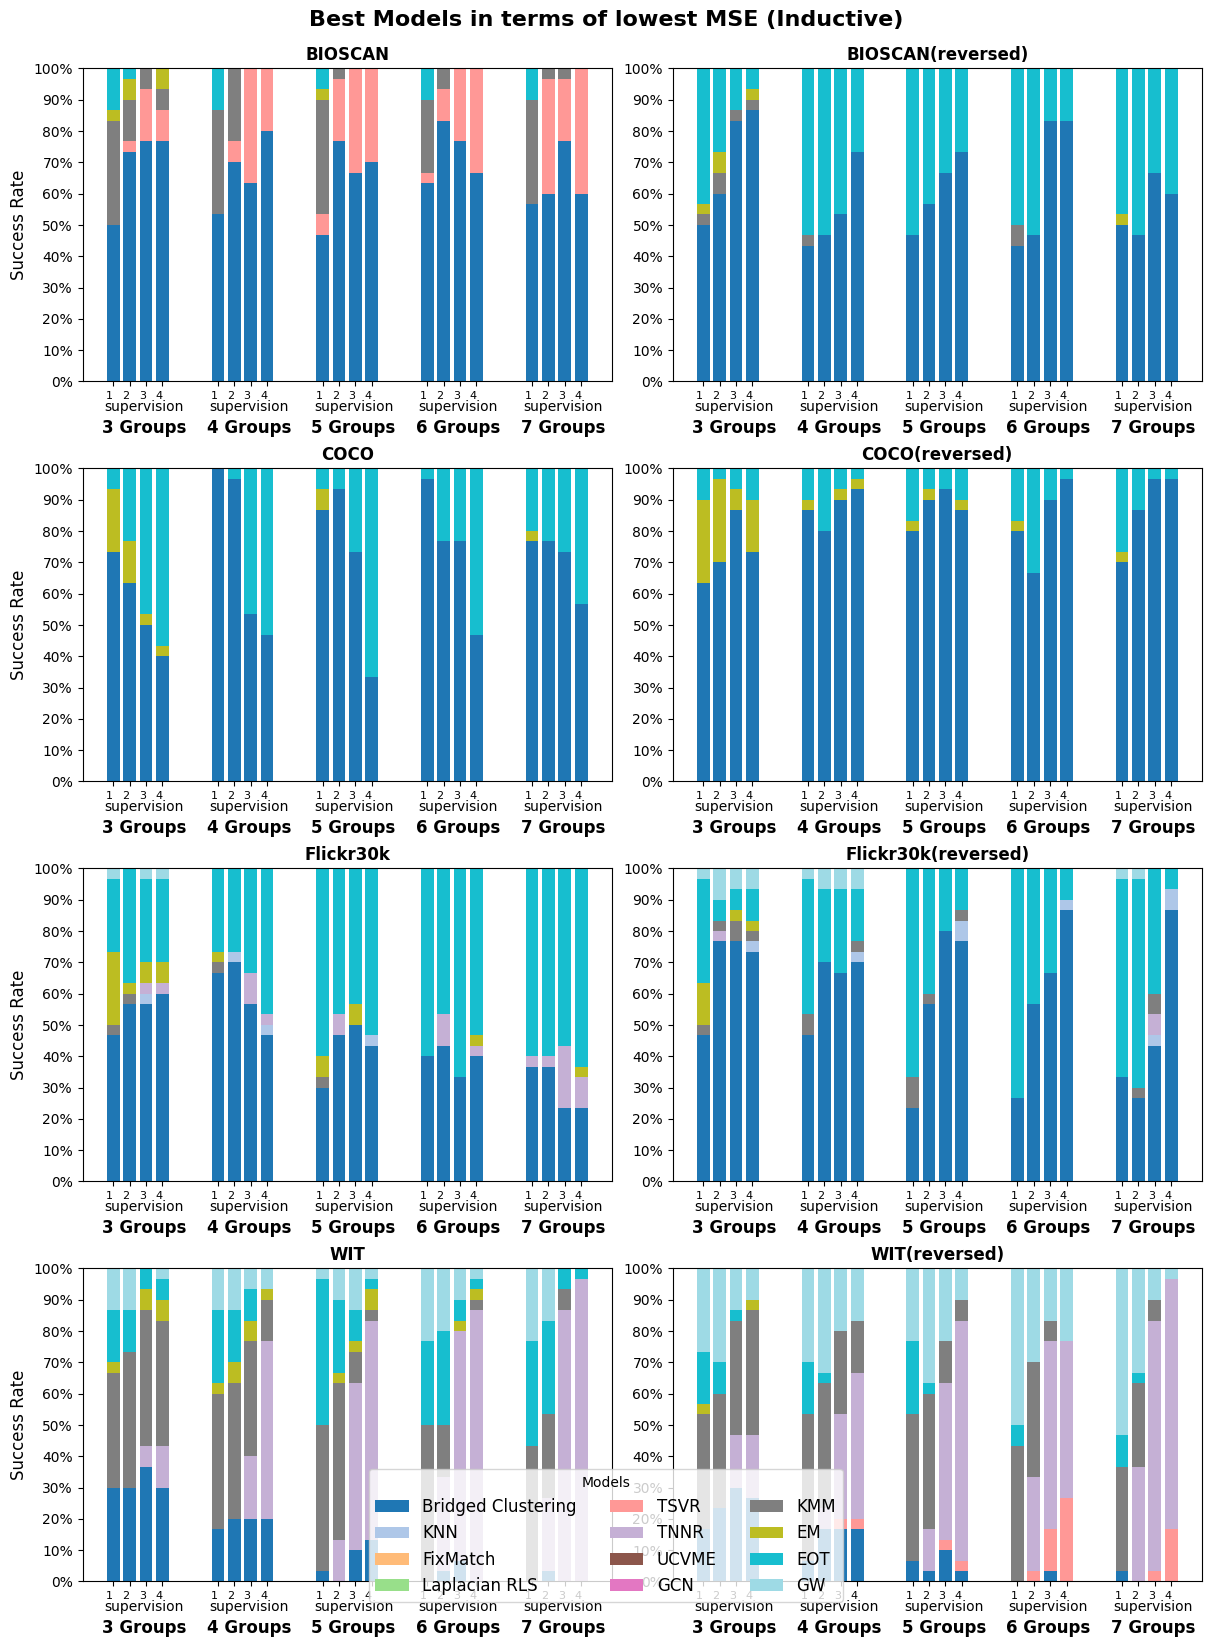

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


experiment_key_list = []

metrics_list = []
for key in experiment_key_list:
    mse = np.load(f"results/{key}/mse.npy")
    if mse.ndim == 6:
        mse = mse[:, 0, :, 0, :, :]
    metrics_list.append(mse)

titles = ["BIOSCAN", "BIOSCAN(reversed)", "COCO", "COCO(reversed)", "Flickr30k", "Flickr30k(reversed)", "WIT","WIT(reversed)"]

def plot_success_rates(ax, metric, title,
                       hyperparam1_labels, hyperparam2_labels, model_labels,
                       choose_metric="mse"):
    n_h1, n_h2, n_models, n_trials = metric.shape
    
    # Compute success rates
    success_rates = np.zeros((n_h1, n_h2, n_models))
    for i in range(n_h1):
        for j in range(n_h2):
            losses = metric[i, j]
            if choose_metric in ("bleu", "chrf"):
                winners = np.argmax(losses, axis=0)
            else:
                winners = np.argmin(losses, axis=0)
            for k in range(n_models):
                success_rates[i, j, k] = np.mean(winners == k)

    # Layout parameters
    bar_width   = 0.18
    intra_gap   = 0.05
    group_gap   = 0.6
    group_width = n_h2 * bar_width + (n_h2 - 1) * intra_gap

    positions = []
    for i in range(n_h1):
        base = i * (group_width + group_gap)
        for j in range(n_h2):
            x = base + j * (bar_width + intra_gap)
            positions.append(x)
    positions = np.array(positions)

    # Colors
    cmap   = plt.get_cmap('tab20')
    colors = [cmap(t) for t in np.linspace(0, 1, n_models)]

    # Plot
    for idx, x in enumerate(positions):
        bottom = 0.0
        i = idx // n_h2
        j = idx % n_h2
        for k in range(n_models):
            rate = success_rates[i, j, k]
            ax.bar(x, rate, bar_width, bottom=bottom, color=colors[k])
            bottom += rate

    # X‑ticks
    ax.set_xticks(positions)
    ax.set_xticklabels(hyperparam2_labels * n_h1,
                       rotation=0, ha='right', fontsize=8)

    # Group labels
    group_centers = [
        i * (group_width + group_gap) + group_width / 2
        for i in range(n_h1)
    ]
    for i, center in enumerate(group_centers):
        ax.text(center, -0.06, "supervision",
                transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize=10)
        ax.text(center, -0.12, hyperparam1_labels[i],
                transform=ax.get_xaxis_transform(),
                ha='center', va='top', fontsize=12, fontweight='bold')

    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 11))
    ax.set_yticklabels([f"{int(tick * 100)}%" for tick in np.linspace(0, 1, 11)])
    ax.set_title(title, fontsize=12, fontweight = 'bold')


# Assume metrics_list, titles, hyperparam1_labels, hyperparam2_labels, model_labels exist
fig, axes = plt.subplots(4, 2, figsize=(12, 16), constrained_layout=True)
axes = axes.flatten()

for idx, (metric, title) in enumerate(zip(metrics_list, titles)):
    ax = axes[idx]
    plot_success_rates(ax, metric, title,
                       hyperparam1_labels, hyperparam2_labels, model_labels)
    # only put y‑label on the left‐column plots
    if idx % 2 == 0:
        ax.set_ylabel("Success Rate", fontsize=12)

# hide any extra axes (if you had >8)
for ax in axes[len(titles):]:
    ax.axis("off")

#shared legend at bottom
fig.legend(
    model_labels,
    title="Models",
    ncol=3,
    bbox_to_anchor=(0.5, 0.02),
    loc="lower center",
    fontsize=12
)
fig.suptitle("Best Models in terms of lowest MSE (Inductive)", fontsize=16, fontweight='bold', y=1.02)
plt.show()


ami_x shape for 101_bioscan_tran: (5, 4, 30)
ami_y shape for 101_bioscan_tran: (5, 4, 30)
accuracy shape for 101_bioscan_tran: (5, 4, 30)
bkm shape for 101_bioscan_tran: (5, 4, 30)
ami_x shape for 102_bioscan_rev_tran: (5, 4, 30)
ami_y shape for 102_bioscan_rev_tran: (5, 4, 30)
accuracy shape for 102_bioscan_rev_tran: (5, 4, 30)
bkm shape for 102_bioscan_rev_tran: (5, 4, 30)
ami_x shape for 100_coco_tran: (5, 4, 30)
ami_y shape for 100_coco_tran: (5, 4, 30)
accuracy shape for 100_coco_tran: (5, 4, 30)
bkm shape for 100_coco_tran: (5, 4, 30)
ami_x shape for 101_coco_rev_tran: (5, 4, 30)
ami_y shape for 101_coco_rev_tran: (5, 4, 30)
accuracy shape for 101_coco_rev_tran: (5, 4, 30)
bkm shape for 101_coco_rev_tran: (5, 4, 30)
ami_x shape for 104_flick_2_tran: (5, 4, 30)
ami_y shape for 104_flick_2_tran: (5, 4, 30)
accuracy shape for 104_flick_2_tran: (5, 4, 30)
bkm shape for 104_flick_2_tran: (5, 4, 30)
ami_x shape for 105_flick_rev_2_tran: (5, 4, 30)
ami_y shape for 105_flick_rev_2_tran: 

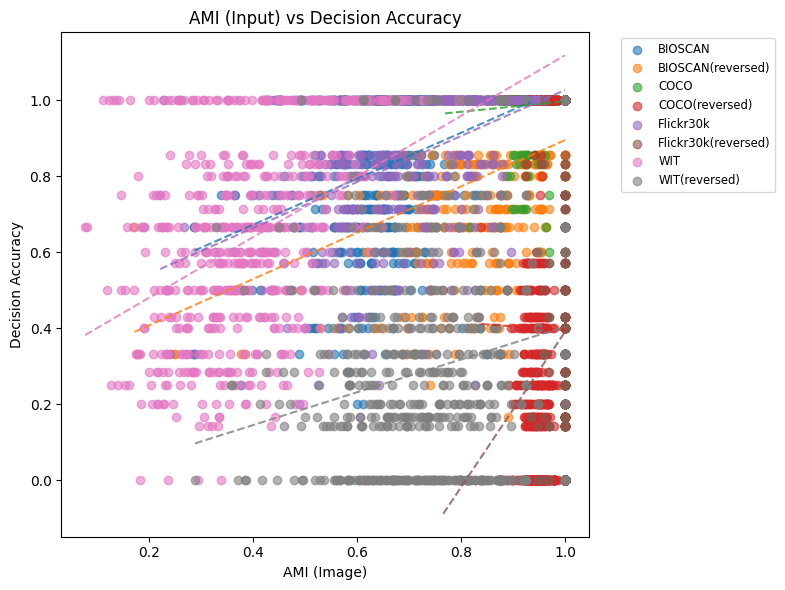

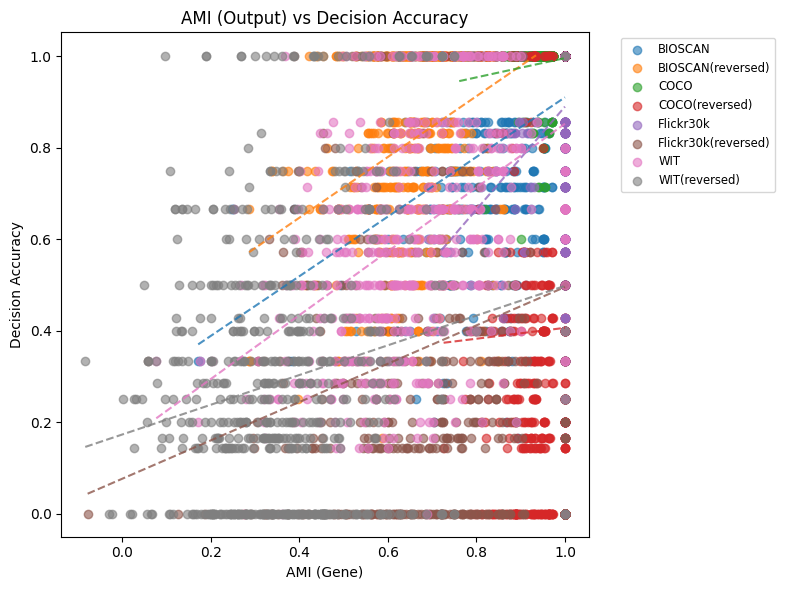

In [ ]:
experiment_key_list = []

ami_x_list = []
ami_y_list = []
accuracy_list = []
bkm_list = []
for key in experiment_key_list:
    ami_x = np.load(f"results/{key}/ami_x.npy")
    ami_y = np.load(f"results/{key}/ami_y.npy")
    accuracy = np.load(f"results/{key}/accuracy.npy")
    bkm = np.load(f"results/{key}/mse.npy")

    # if exists:
    if ami_x.ndim == 5:
        ami_x = ami_x[:, 0, :, 0, :]
        ami_y = ami_y[:, 0, :, 0, :]
        accuracy = accuracy[:, 0, :, 0, :]
        bkm = bkm[:, 0, :, 0, :, :]
    
    bkm = bkm[:,:,0,:]

    #print sizes
    print(f"ami_x shape for {key}:", ami_x.shape)
    print(f"ami_y shape for {key}:", ami_y.shape)
    print(f"accuracy shape for {key}:", accuracy.shape)
    print(f"bkm shape for {key}:", bkm.shape)

    ami_x_list.append(ami_x)
    ami_y_list.append(ami_y)
    accuracy_list.append(accuracy)
    bkm_list.append(bkm)

set_labels = titles

# choose a colormap with at least 6 distinct colors
colors = plt.cm.tab10.colors  # tab10 has 10; we'll just use the first 6

def plot_multi(x_list, y_list, labels, x_label, y_label, title):
    plt.figure(figsize=(8, 6))
    for idx, (X, Y, lbl) in enumerate(zip(x_list, y_list, labels)):
        # flatten all (hyperparam × trials) into one long vector each
        x_flat = X.reshape(-1)
        y_flat = Y.reshape(-1)

        # scatter
        plt.scatter(
            x_flat,
            y_flat,
            color=colors[idx],
            label=lbl,
            alpha=0.6
        )

        # best‐fit line
        slope, intercept = np.polyfit(x_flat, y_flat, 1)
        x_line = np.linspace(x_flat.min(), x_flat.max(), 100)
        y_line = slope * x_line + intercept
        plt.plot(
            x_line,
            y_line,
            color=colors[idx],
            linestyle='--',
            linewidth=1.5,
            alpha=0.8
        )

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend(
        bbox_to_anchor=(1.05, 1),
        loc='upper left',
        fontsize='small'
    )
    plt.tight_layout()


# --- 2) Generate your five combined plots ---

# AMI (Image) vs Decision Accuracy
plot_multi(
    ami_x_list,
    accuracy_list,
    set_labels,
    x_label="AMI (Image)",
    y_label="Decision Accuracy",
    title="AMI (Input) vs Decision Accuracy"
)

# AMI (Gene) vs Decision Accuracy
plot_multi(
    ami_y_list,
    accuracy_list,
    set_labels,
    x_label="AMI (Gene)",
    y_label="Decision Accuracy",
    title="AMI (Output) vs Decision Accuracy"
)


plt.show()

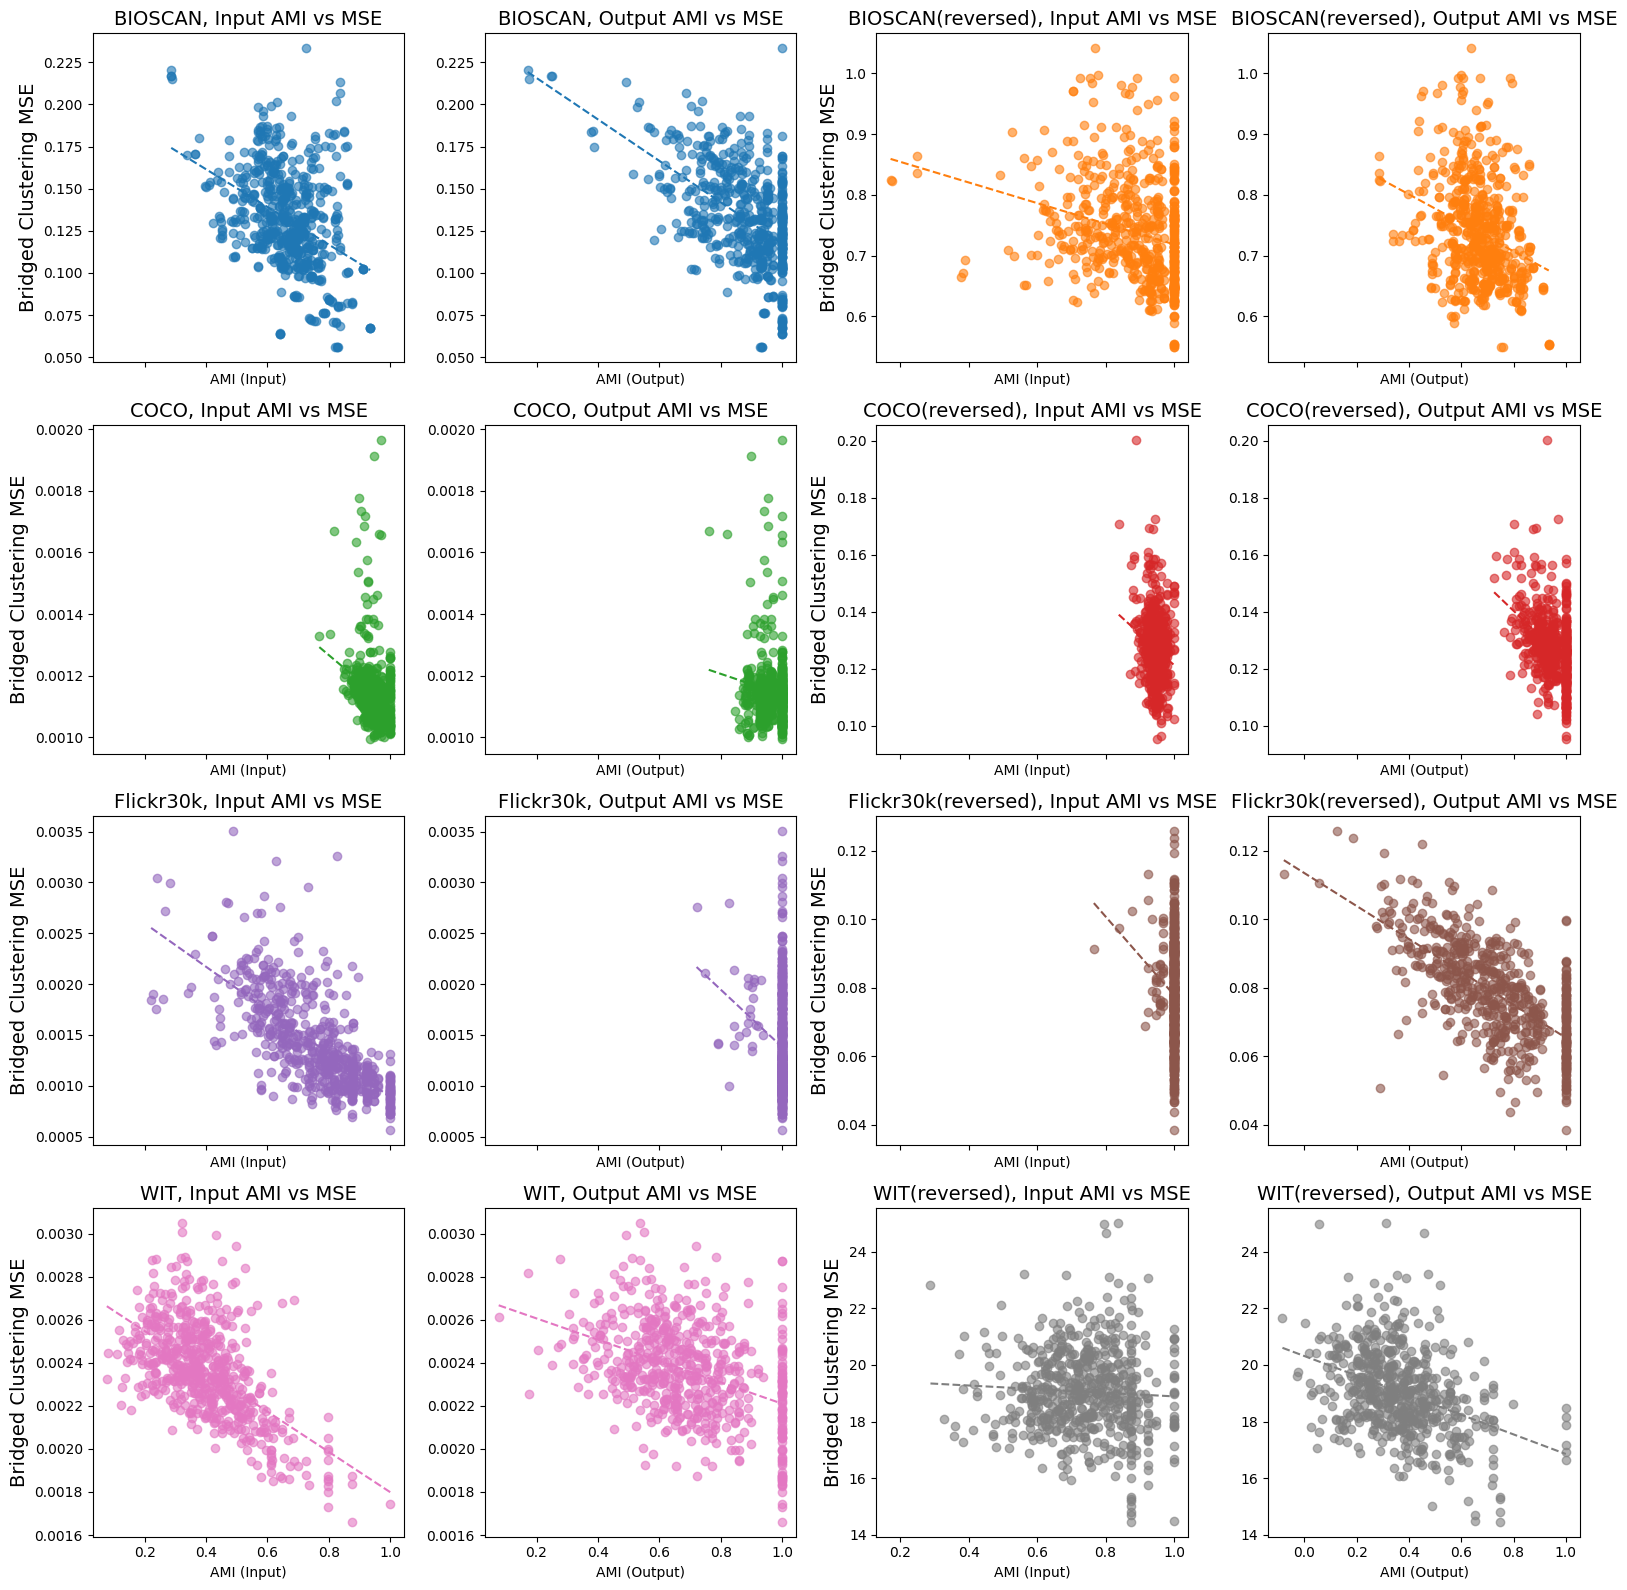

In [ ]:
labels = titles

# choose 8 distinct colors
colors = plt.cm.tab10.colors

# --- 2) Build a 4×4 grid: pairs of columns per experiment ---
fig, axes = plt.subplots(4, 4, figsize=(16, 16), sharex='col')
for idx in range(8):
    row = idx // 2
    pair = idx % 2
    col_x = pair * 2      # 0 or 2
    col_y = col_x + 1     # 1 or 3

    x_vals = ami_x_list[idx].reshape(-1)
    y_vals = bkm_list[idx].reshape(-1)

    # Left plot: AMI (Image) vs BKM
    ax = axes[row, col_x]
    ax.scatter(x_vals, y_vals,
               color=colors[idx], alpha=0.6)
    # best-fit line
    m, b = np.polyfit(x_vals, y_vals, 1)
    xs = np.linspace(x_vals.min(), x_vals.max(), 100)
    ax.plot(xs, m*xs + b,
            color=colors[idx], linestyle='--', linewidth=1.5)
    ax.set_title(f"{labels[idx]}, Input AMI vs MSE", fontsize=14)
    ax.set_xlabel("AMI (Input)")
    ax.set_ylabel("Bridged Clustering MSE", fontsize=14)

    # Right plot: AMI (Gene) vs BKM, same color
    ay = axes[row, col_y]
    x2 = ami_y_list[idx].reshape(-1)
    ay.scatter(x2, y_vals,
               color=colors[idx], alpha=0.6)
    m2, b2 = np.polyfit(x2, y_vals, 1)
    xs2 = np.linspace(x2.min(), x2.max(), 100)
    ay.plot(xs2, m2*xs2 + b2,
            color=colors[idx], linestyle='--', linewidth=1.5)
    ay.set_title(f"{labels[idx]}, Output AMI vs MSE", fontsize=14)
    ay.set_xlabel("AMI (Output)")
    ay.set_ylabel("")  # omit duplicate y-label if you like

fig.tight_layout()
plt.show()

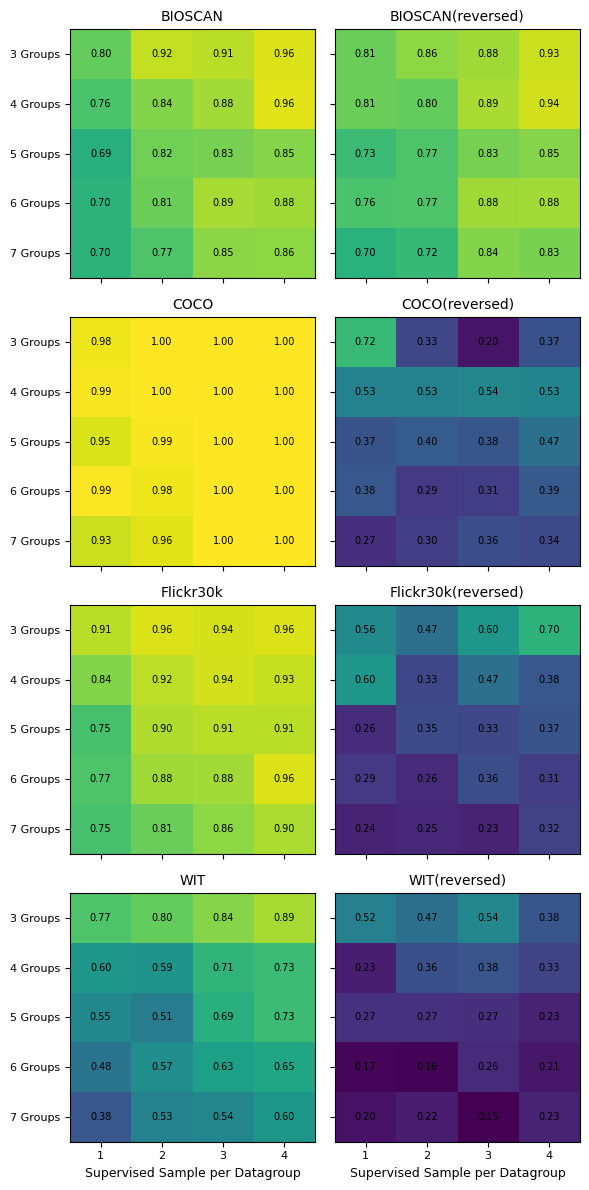

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

experiment_key_list = []
experiment_titles = ["BIOSCAN", "BIOSCAN(reversed)", "COCO", "COCO(reversed)", "Flickr30k", "Flickr30k(reversed)", "WIT","WIT(reversed)"]

# assume hyperparam1_labels and hyperparam2_labels are defined
data_list = []
for key in experiment_key_list:
    mat = np.load(f"results/{key}/accuracy.npy")
    if mat.ndim == 5:
        mat = mat[:, 0, :, 0, :]
    data_list.append(np.mean(mat, axis=2))

# get common color limits
all_data = np.stack(data_list)
vmin, vmax = all_data.min(), all_data.max()

n = len(data_list)
ncols = 2
nrows = int(np.ceil(n / ncols))

# use a narrower width
fig, axes = plt.subplots(nrows, ncols, figsize=(6, nrows * 3), 
                         sharex=True, sharey=True)
axes = axes.flatten()

for idx, data in enumerate(data_list):
    ax = axes[idx]
    im = ax.imshow(data, aspect='auto', vmin=vmin, vmax=vmax)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            ax.text(j, i, f"{data[i, j]:.2f}", ha='center', va='center', fontsize=7)
    ax.set_xticks(range(len(hyperparam2_labels)))
    ax.set_yticks(range(len(hyperparam1_labels)))
    ax.set_xticklabels(hyperparam2_labels, fontsize=8)
    ax.set_yticklabels(hyperparam1_labels, fontsize=8)
    ax.set_title(experiment_titles[idx], fontsize=10)
    if idx // ncols == nrows - 1:
        ax.set_xlabel('Supervised Sample per Datagroup', fontsize=9)

# drop any unused axes
for idx in range(n, nrows * ncols):
    fig.delaxes(axes[idx])

# tighten horizontal spacing
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.tight_layout()
plt.show()


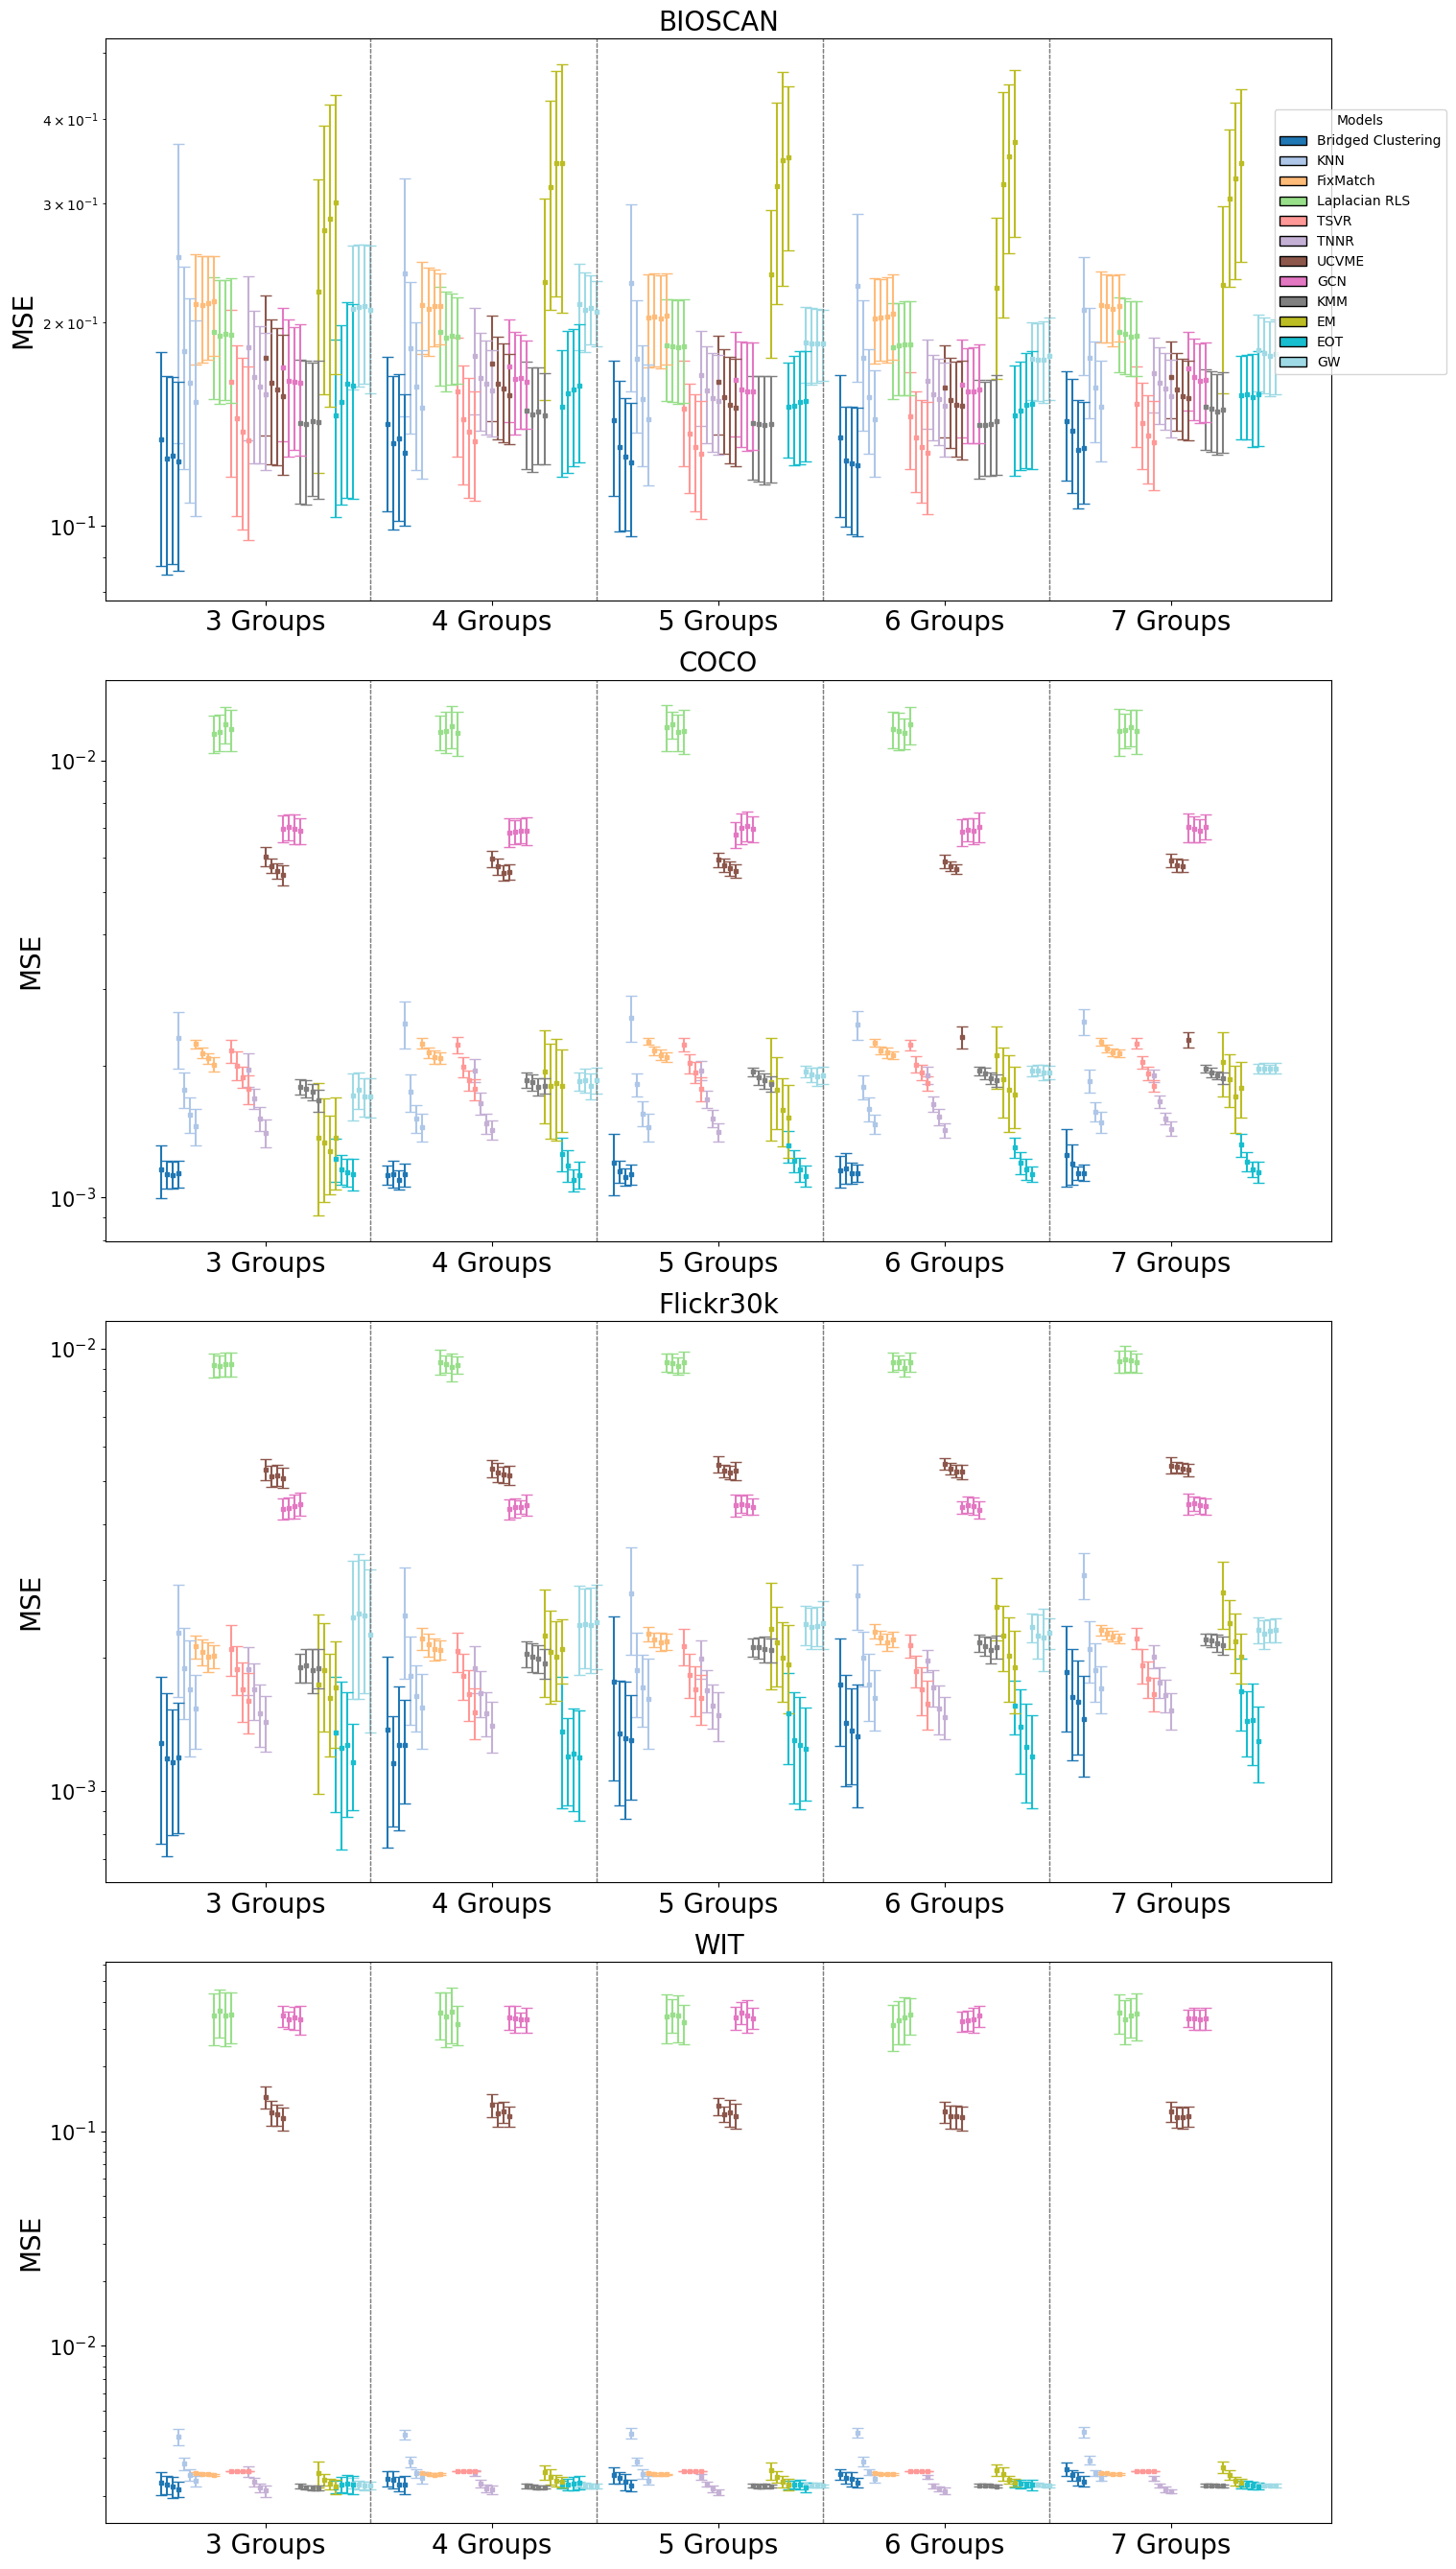

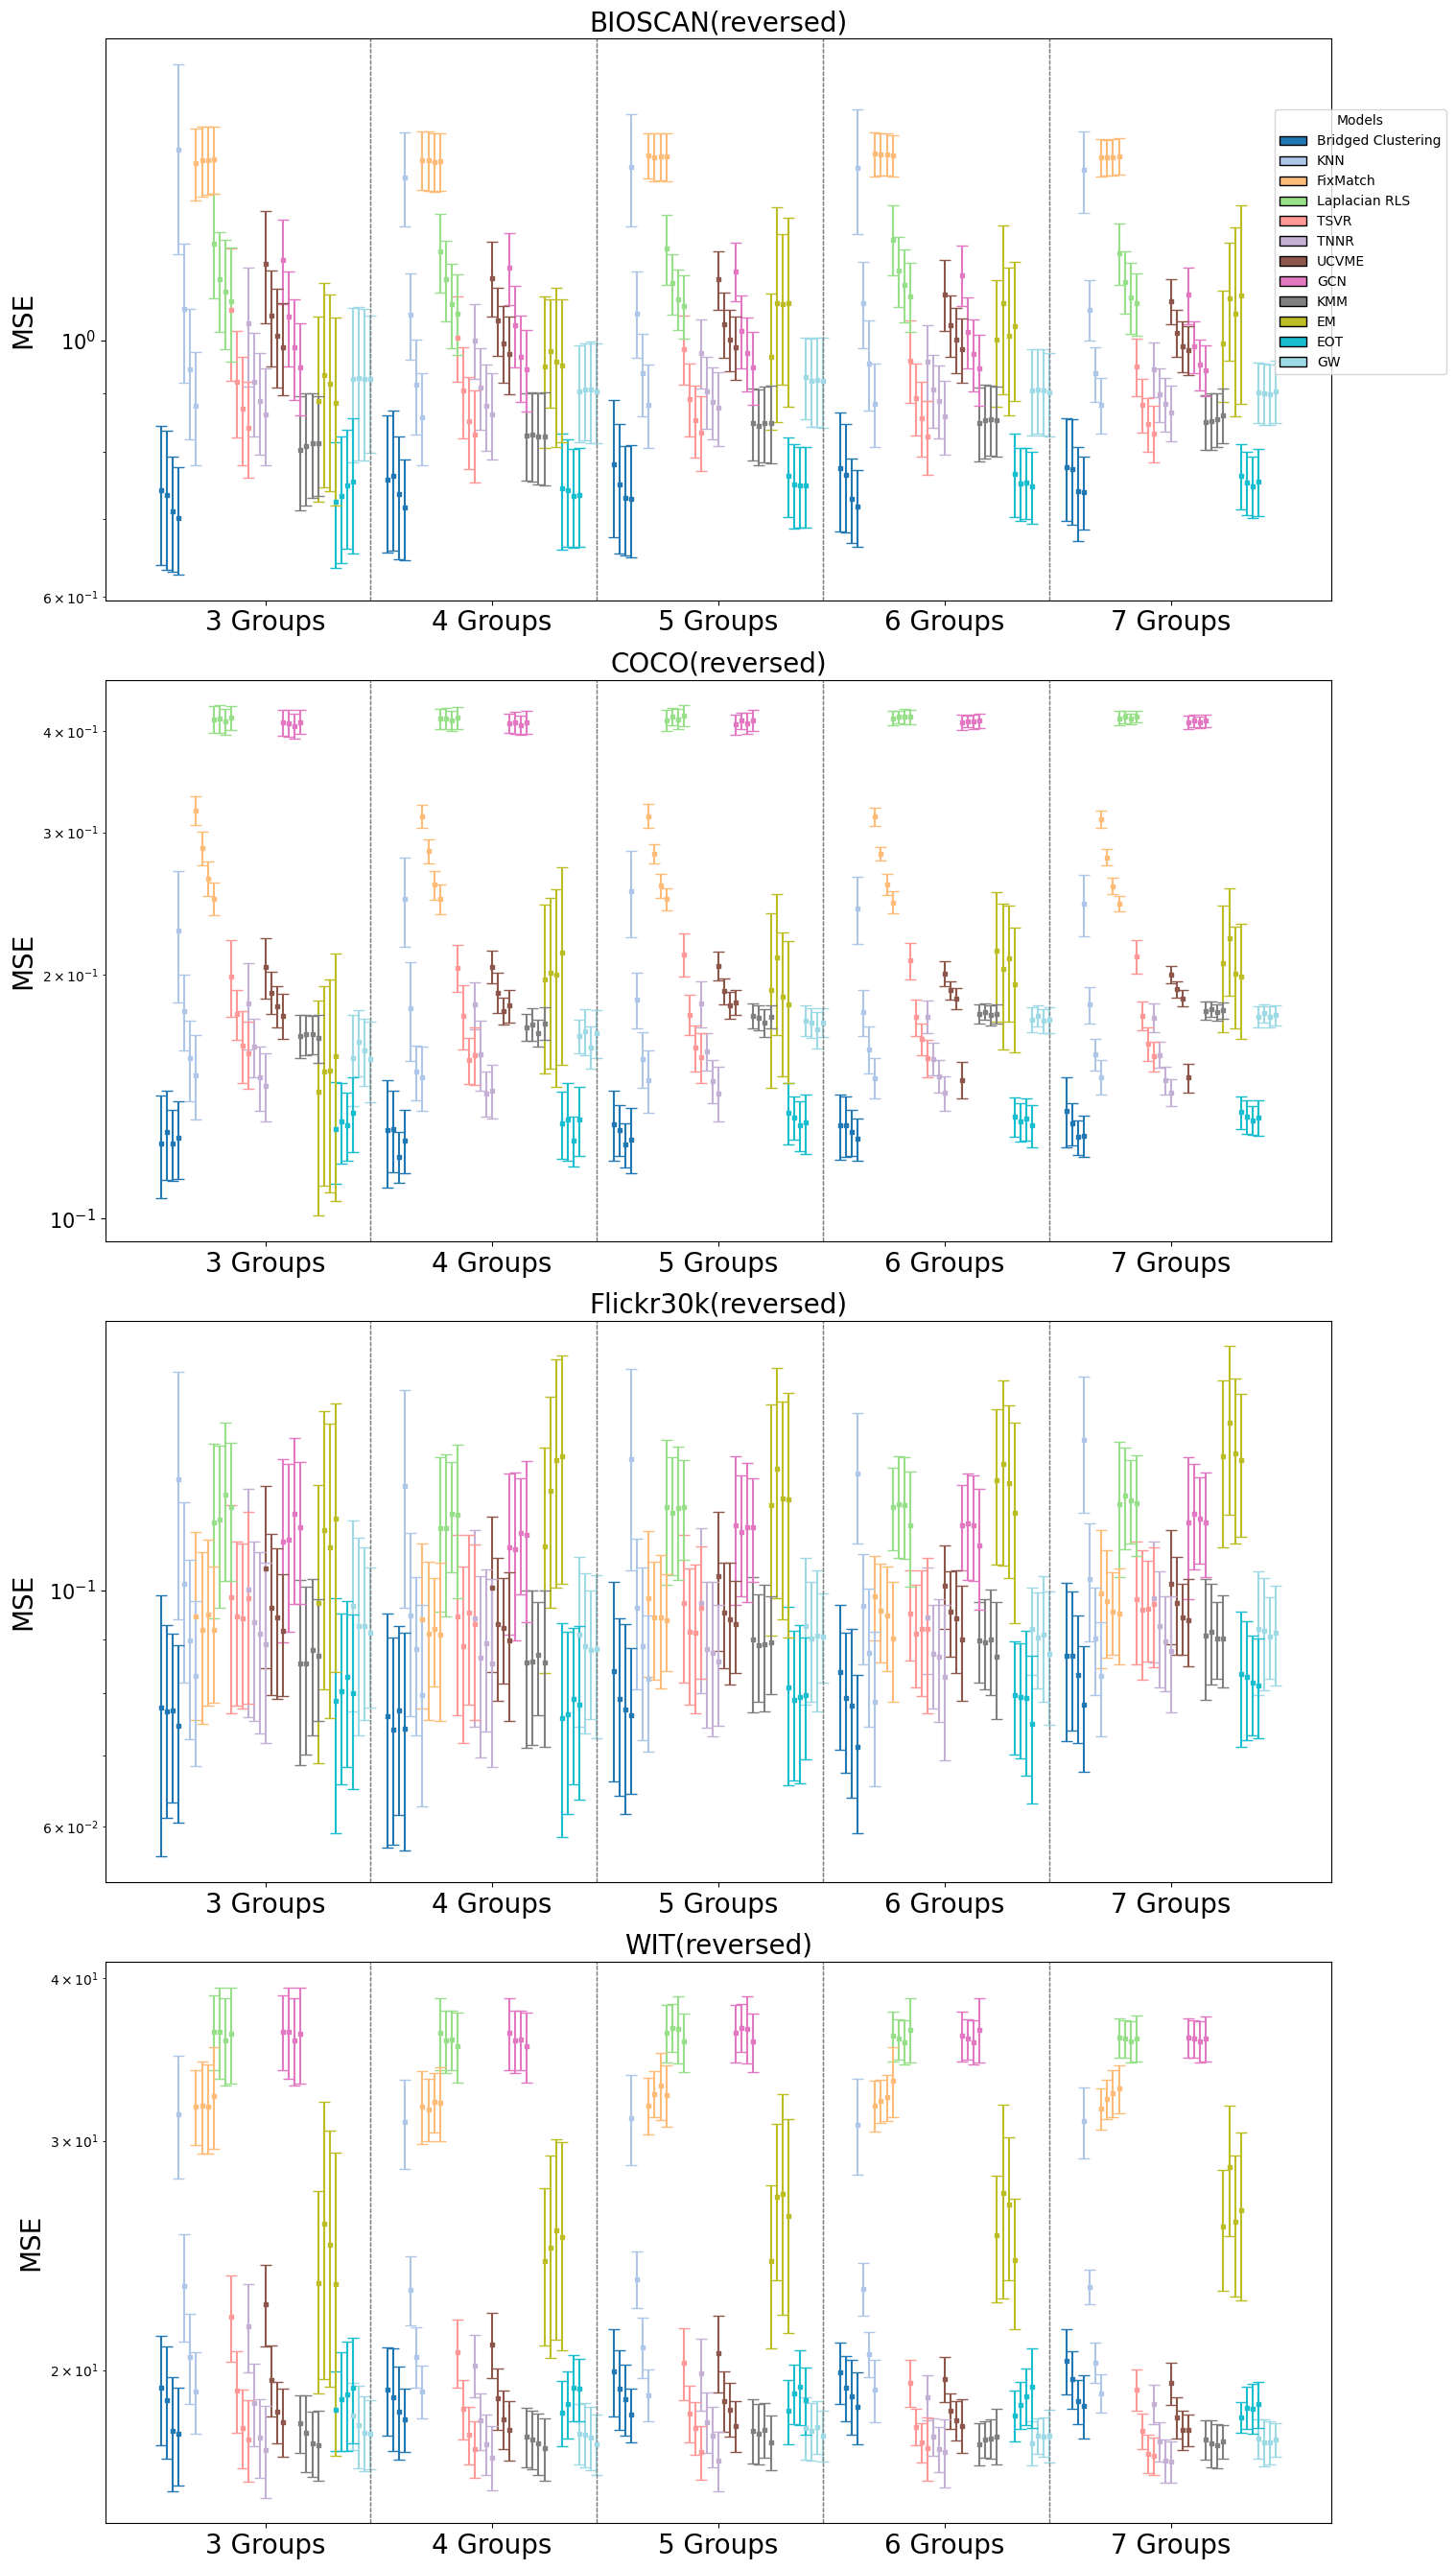

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math

# 1) CONFIGURATION
experiment_key_list = []
experiment_titles = ["BIOSCAN", "BIOSCAN(reversed)", "COCO", "COCO(reversed)", "Flickr30k", "Flickr30k(reversed)", "WIT","WIT(reversed)"]
# 2) LOAD ALL DATA ONCE
all_data = []
for key in experiment_key_list:
    arr = np.load(f"results/{key}/mse.npy")
    if arr.ndim == 6:
        arr = arr[:, 0, :, 0, :, :]   # unwrap if necessary
    arr = np.delete(arr, [2,8], axis=2)
    all_data.append(arr)

num_h1, num_h2, num_models, _ = all_data[0].shape

# color palette
cmap   = plt.get_cmap('tab20', num_models)
colors = [cmap(i) for i in range(num_models)]

# offset settings (deterministic ordering by hyperparam2 index)
offset_width = 1.0

# 3) DEFINE A PLOTTING FUNCTION
def plot_group(idxs, group_name):
    n = len(idxs)
    ncols = 1
    nrows = n
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(16, nrows * 7),  # narrower figure
                             sharex=False, sharey=False)
    # if axes is 1D for nrows>1, keep it as is; if nrows==1 it’s a single Axes
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]

    for ax, idx in zip(axes, idxs):
        loss_data = all_data[idx]
        title     = experiment_titles[idx]

        # for each hyperparam1 block
        for i in range(num_h1):
            base = i * (num_models + 1)
            for j in range(num_h2):
                dx = (j / (num_h2 - 1) - 0.5) * offset_width
                for m in range(num_models):
                    vals  = loss_data[i, j, m, :]
                    mu    = vals.mean()
                    sigma = vals.std(ddof=0)
                    x     = base + m + 1 + dx
                    ax.errorbar(x, mu, yerr=sigma,
                                fmt='s', markersize=3, capsize=4,
                                color=colors[m])

            # separator lines
            for grp in range(num_h1 - 1):
                x0 = (grp + 1) * (num_models + 1) - 0.5
                ax.axvline(x=x0, color='gray',
                           linestyle='--', linewidth=0.8)

        # ticks & labels
        centers = [
            np.mean(range(i*(num_models+1)+1,
                         i*(num_models+1)+1+num_models))
            for i in range(num_h1)
        ]
        ax.set_xticks(centers)
        ax.set_xticklabels(hyperparam1_labels, fontsize=20)
        ax.set_title(title, fontsize=20)
        ax.set_ylabel("MSE", fontsize=20)
        ax.set_yscale('log')
        ax.tick_params(axis='y', labelsize=15)
        ax.grid(False)

    # shared legend
    handles = [
        Patch(facecolor=colors[k], edgecolor='k', label=model_labels[k])
        for k in range(num_models)
    ]
    fig.legend(handles=handles,
               loc='upper right', bbox_to_anchor=(0.95, 0.92),
               fontsize=10, title="Models")

    plt.tight_layout(rect=[0, 0, 0.88, 0.96])
    plt.show()


# 4) PLOT TWO SEPARATE FIGURES
standard_idxs = [0, 2, 4, 6]  # BIOSCAN, WIT, Flickr30k, COCO
reversed_idxs = [1, 3, 5, 7]  # the “(reversed)” experiments

plot_group(standard_idxs, "Standard Experiments")
plot_group(reversed_idxs, "Reversed Experiments")

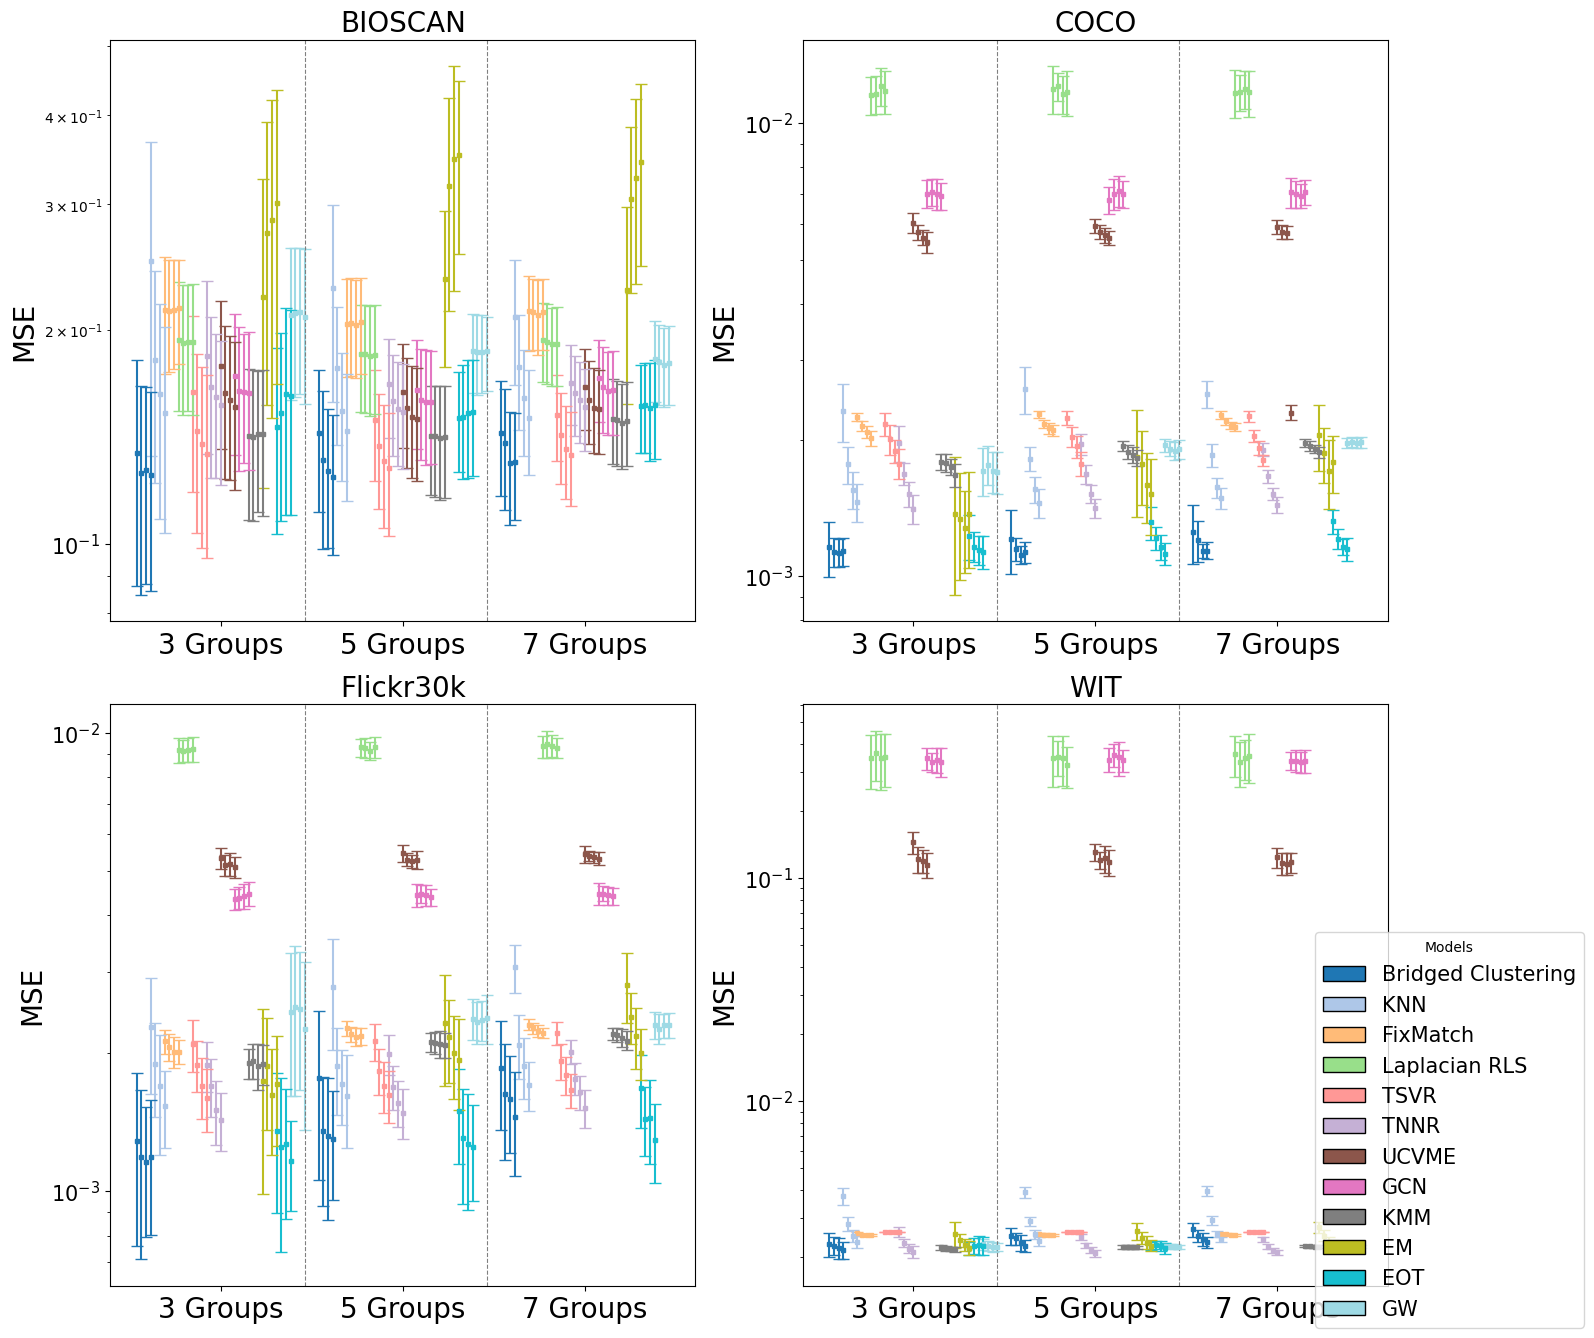

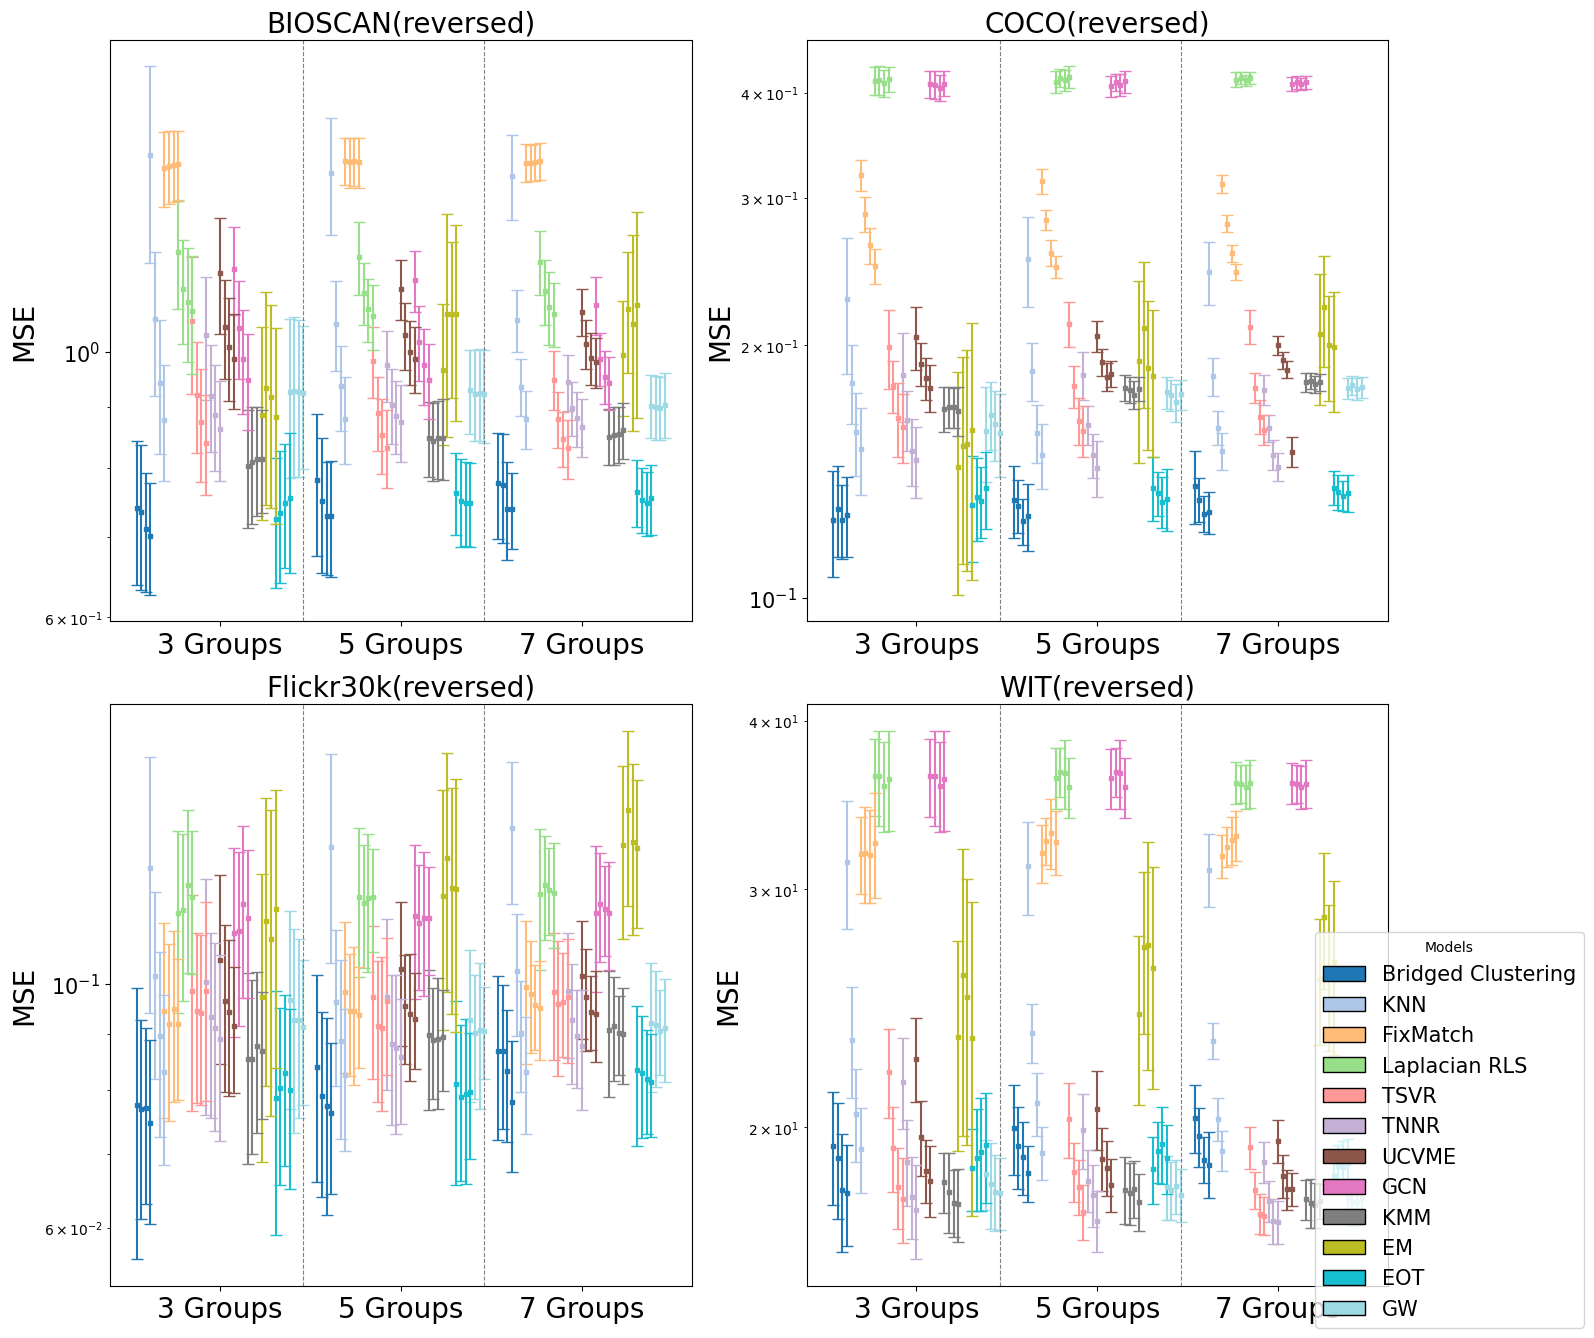

In [ ]:
experiment_key_list = []
experiment_titles = ["BIOSCAN", "BIOSCAN(reversed)", "COCO", "COCO(reversed)", "Flickr30k", "Flickr30k(reversed)", "WIT","WIT(reversed)"]
# 2) LOAD ALL DATA ONCE
all_data = []
for key in experiment_key_list:
    arr = np.load(f"results/{key}/mse.npy")
    if arr.ndim == 6:
        arr = arr[:, 0, :, 0, :, :]   # unwrap if necessary
    arr = np.delete(arr, [2,8], axis=2)
    all_data.append(arr)

    
def plot_group(idxs, group_name, selected_h1_idx=SELECTED_H1):
    n = len(idxs)
    # force a 2x2 grid if there are 4 experiments
    nrows, ncols = (2, 2) if n == 4 else (math.ceil(n/2), 2)

    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(16, nrows * 7),
                             sharex=False, sharey=False)
    axes = np.array(axes).reshape(-1)  # flatten grid to 1D list

    # Precompute label subset
    h1_labels_shown = [hyperparam1_labels[i] for i in selected_h1_idx]
    num_h1_shown = len(selected_h1_idx)

    for ax, idx in zip(axes, idxs):
        loss_data = all_data[idx]
        title     = experiment_titles[idx]

        for i_pos, i_h1 in enumerate(selected_h1_idx):
            base = i_pos * (num_models + 1)
            for j in range(num_h2):
                dx = (j / (num_h2 - 1) - 0.5) * offset_width if num_h2 > 1 else 0.0
                for m in range(num_models):
                    vals  = loss_data[i_h1, j, m, :]
                    mu    = vals.mean()
                    sigma = vals.std(ddof=0)
                    x     = base + m + 1 + dx
                    ax.errorbar(x, mu, yerr=sigma,
                                fmt='s', markersize=3, capsize=4,
                                color=colors[m])

        # separator lines
        for grp in range(num_h1_shown - 1):
            x0 = (grp + 1) * (num_models + 1) - 0.5
            ax.axvline(x=x0, color='gray', linestyle='--', linewidth=0.8)

        centers = [
            np.mean(range(i_pos*(num_models+1)+1,
                          i_pos*(num_models+1)+1+num_models))
            for i_pos in range(num_h1_shown)
        ]
        ax.set_xticks(centers)
        ax.set_xticklabels(h1_labels_shown, fontsize=20)
        ax.set_title(title, fontsize=20)
        ax.set_ylabel("MSE", fontsize=20)
        #ytick size should be larger
        ax.tick_params(axis='y', labelsize=15)
        ax.set_yscale('log')
        ax.grid(False)

    # Hide unused subplots if n < nrows*ncols
    for ax in axes[len(idxs):]:
        ax.set_visible(False)

    handles = [Patch(facecolor=colors[k], edgecolor='k', label=model_labels[k])
               for k in range(num_models)]
    fig.legend(handles=handles,
               loc='lower right',
               fontsize=15, title="Models")

    plt.tight_layout(rect=[0, 0, 0.88, 0.96])
    plt.show()


# 4) PLOT TWO SEPARATE FIGURES (unchanged indices; now only 1st/3rd/5th h1 shown)
standard_idxs = [0, 2, 4, 6]
reversed_idxs = [1, 3, 5, 7]

plot_group(standard_idxs, "Standard Experiments")
plot_group(reversed_idxs, "Reversed Experiments")
